# EchoB binary data: unpacking, cleaning, manipulating

It is possible to directly extract and manipulate the data output by the Telemed Echo Blaster (EchoB), rather than making use of software such as Articulate Assistant Advanced as an intermediary. We will go through this procedure below, extracting frames from the raw binary data with the `struct` library - we can then play around with the resulting data, using `ultratils` utilities and other approaches, to demonstrate the possibilities of the format.

Some initial imports:

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
% matplotlib inline

## Extracting a frame array

The ultrasound video data comes to us as a continuous stream, with each new frame's data simply concatenated to the end of the data already collected. So, successful extraction of a frame (or any frames at all) depends on knowing the dimensions of the output image array (in pixels). This will allow us to figure out how many bytes in the raw data a frame is. 

Through trial and error, I settle on 127 pixels wide by 255 pixels tall. The number of bytes that make up a frame is four times the product of these numbers, since each pixel requires four bytes to represent in the binary data.

In [2]:
frame_dim_1 = 127
frame_dim_2 = 255

frame_size = frame_dim_1 * frame_dim_2 * 4
frame_size

129540

The `nth` frame in the recorded ultrasound video will start `n * frame_size` bits into the data. Putting this into a convenience function:

In [3]:
def get_frame(filename, frame_idx, frame_dim_1, frame_dim_2):
    """
      Inputs: filename, index of frame, frame width and height
      Outputs: ndarray containing frame
    """
    data_fmt = 'I' * np.int(frame_dim_1 * frame_dim_2) # unsigned int (I) times dimensions of output image
    framesize = frame_dim_1 * frame_dim_2 * 4 # multiply by 4 to get number of bytes (4 bytes/pixel)
    frame_start = frame_idx * framesize
    with open(filename, 'rb') as fh:
        fh.seek(frame_start) # move pointer to start of frame
        packed_data = fh.read(framesize) # take a frame-sized chunk at this coord
        try:
            unpacked_data = struct.unpack(data_fmt, packed_data) # conversion to array
        except:
            print("No data at position {}".format(frame_idx)) # catch out-of-range indices
            rdata = None
        else:
            data = np.array(unpacked_data)
            rdata = data[np.arange(frame_dim_1 * frame_dim_2)].reshape(frame_dim_1, frame_dim_2).T
            rdata = rdata.astype(np.uint8) # for plotting
            
        return(rdata)

Putting it all together, let's extract the 70th frame in the data.

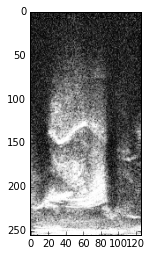

In [4]:
rf = '2017-04-07T005430-0700.raw' # read in file
rawdata = get_frame(rf, 70, 127,255)
plt.imshow(np.flipud(rawdata), cmap="Greys_r") # visualize the resulting array

## Displaying to physical scale

Now that we have extracted a frame, we can see that it is not yet in the expected "fan" shape. This is a problem if we need the tongue contour to meaningfully correspond to the physical dimensions of the vocal tract. Enter `ultratils` and its fan-conversion utilities. The `Converter` class, once instantiated with a header containing image dimension information and some information on the ultrasound probe, can convert "rectangular" data like the frame above to the desired "fan" shape. Some information on the ultrasound probe has been determined through trial and error.

In [5]:
from ultratils.pysonix.scanconvert import Converter

class Header(object):
    def __init__(self):
        pass

class Probe(object):
    def __init__(self):
        pass
    
header = Header()
header.w = 127          # input image width
header.h = 255          # input image height
header.sf = 4000000     # magic number, sorry!

probe = Probe()
probe.radius = 10000    # based on '10' in transducer model number
probe.numElements = 128 # based on '128' in transducer model number
probe.pitch = 185       # best guess based on Ultrasonix C9-5/10 transducer

# instantiate converter
conv = Converter(header, probe)

And with that, we can convert to:

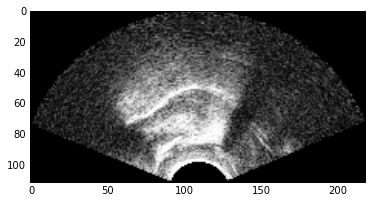

In [6]:
fandata = conv.as_bmp(rawdata)
plt.imshow(np.flipud(fandata), cmap = "Greys_r")

## Noise reduction
This image shows a large amount of speckle noise, which is characteristic of ultrasound imaging in general. We can apply a quick series of filtering operations to reduce the speckle noise and emphasize the tongue contour.

In [14]:
from scipy.ndimage import median_filter # removes some speckle noise
from scipy.ndimage.filters import gaussian_laplace # sharpens edges, i.e. the tongue contour

def clean_frame(frame, median_radius=6, log_sigma=4):
    """
      Input: ndarray image, filter kernel settings
      Output: cleaned ndarray image
    """
    # TODO scale input image
    frame = frame.astype(np.int64)

    # apply median filter, then add LoG mask
    medfilt = median_filter(frame, median_radius)
    logmask = gaussian_laplace(medfilt, log_sigma)
    cleaned = medfilt + logmask
    cleaned = cleaned.astype(np.uint8)
    
    return cleaned

Running our frame from above through, we get this:

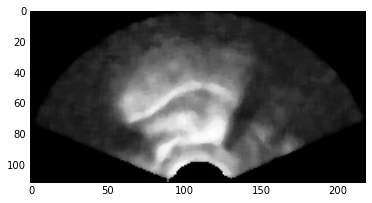

In [16]:
cleaned = clean_frame(fandata)
plt.imshow(np.flipud(cleaned), cmap="Greys_r")

## Fun data manipulations
Now that we can extract, convert, and filter any of the data from the original ultrasound video file, we can explore some more unusual ways to store and display the data. For instance, we can extract all frames, convert them, filter them, store them in an ndarray ...

In [17]:
length_of_array = 140
array_fans = np.empty([length_of_array] + list(fandata.shape)) * np.nan
array_fans = array_fans.astype(np.uint8)
    
for idx in range(0,140):
    rawdata = get_frame(rf, idx, 127,255)
    fandata = conv.as_bmp(rawdata)
    cleaned = clean_frame(fandata.astype(np.uint8))
    #cleaned = cleaned.astype(np.uint8)
    
    array_fans[idx,:,:] = np.flipud(cleaned)

... and make a GIF out of them. (The `gif` function below is defined as in __[this Gist](https://gist.github.com/nirum/d4224ad3cd0d71bfef6eba8f3d6ffd59)__ by GitHub user `nirum`.)

In [20]:
out = gif("sae-cleaned.gif", array_fans)


[MoviePy] Building file sae-cleaned.gif with imageio


100%|██████████| 140/140 [00:05<00:00, 25.05it/s]


Which gives us:
![sae-clean](./sae-clean.gif "sae-clean")

We can also mimic M-mode ultrasound, which is a series of one-dimensional slices (one pixel wide) concatenated into an image that represents a time series. Each one-pixel-wide column in the unconverted ("rectangular") data is a scan line that points radially outward in the converted ("fan") data. Below, the line drawn vertically in the unconverted data at left ends up as a diagonal line in the converted data at right.

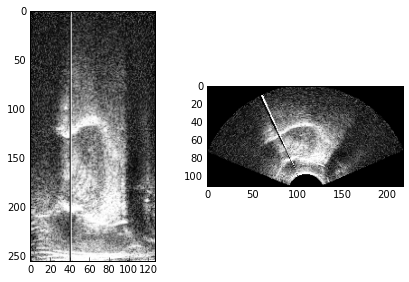

In [21]:
moddata = rawdata.copy()
moddata[:,40] = 0 # highlight a scan line - column 40
moddata[:,41] = 255 # for contrast - column 41

# plot unconverted data (L), converted data (R)
plt.subplot(1,2,1)
plt.imshow(np.flipud(moddata), cmap="Greys_r")
plt.subplot(1,2,2)
plt.imshow(np.flipud(conv.as_bmp(moddata)), cmap="Greys_r")
plt.tight_layout()
plt.show()

If we take these slices of the unconverted data and store them in an array ...

In [22]:
length_of_array = 140
scanline = rawdata[:,40]
array_scans = np.empty([length_of_array] + list(scanline.shape)) * np.nan
array_scans = array_scans.astype('uint8')
    
for idx in range(0,140):
    rawdata = get_frame(rf, idx, 127,255)
    scanline = rawdata[:,40]
    array_scans[idx,:] = scanline

... we can plot all of them as a time series. In the resulting image below, the brightest contour (between 100 and 150 on the Y axis) corresponds to the tongue blade's distance from the probe across the entire recording.

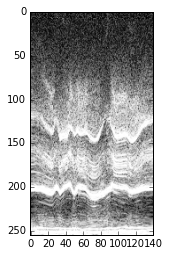

In [23]:
plt.imshow(np.rot90(array_scans), cmap="Greys_r")